<a href="https://colab.research.google.com/github/hebaismail6848/Machine-Deep-learning-projects/blob/main/Face_Mask_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import MaxPooling2D, Conv2D, Dense, BatchNormalization, Flatten, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from google.colab.patches import cv2_imshow
from skimage.io import imshow
from PIL import Image
from sklearn.model_selection import train_test_split
#!pip install kaggle

## Downloading dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# creating new directory named kaggle then copying the .json file in it
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

 98% 160M/163M [00:00<00:00, 342MB/s]
100% 163M/163M [00:00<00:00, 328MB/s]


In [ ]:
# extracting the compressed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

!ls   # list of all files in the directory

The dataset is extracted
data  drive  face-mask-dataset.zip  sample_data


In [ ]:
# defining paths for the data
with_mask_path = '/content/data/with_mask/'
without_mask_path = '/content/data/without_mask/'

# creating list for all files in each class folder
with_mask = os.listdir(with_mask_path)
without_mask = os.listdir(without_mask_path)

## Check balance of the dataset

Text(0.5, 1.0, 'Number of images')

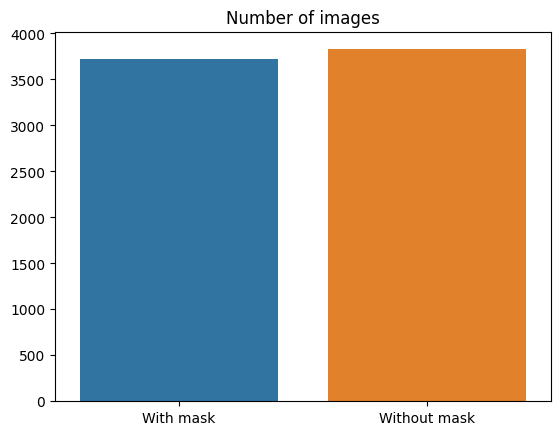

In [ ]:
sns.barplot(x = ['With mask','Without mask'], y = [len(with_mask), len(without_mask)])
plt.title('Number of images')

## Displaying some images

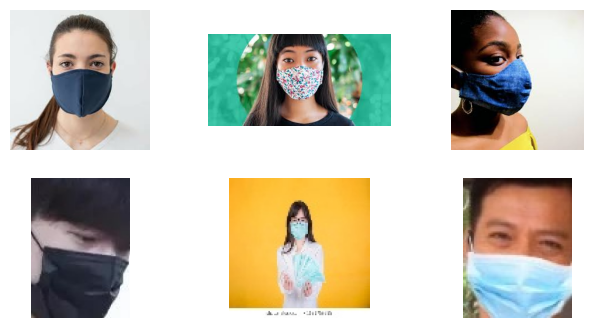

In [ ]:
# displaying some with-mask image

plt.figure(figsize = (8,4))
for i, v in enumerate(np.random.randint(0,len(with_mask), 6)):
    plt.subplot(2,3,i+1)
    img = plt.imread(with_mask_path+ with_mask[v])
    plt.imshow(img)
    plt.axis('off')

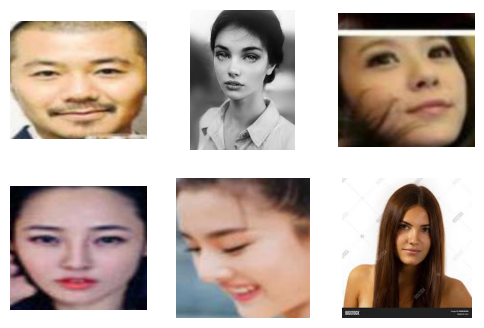

In [ ]:
# displaying some without-mask image

plt.figure(figsize = (6,4))
for i, v in enumerate(np.random.randint(0,len(without_mask), 6)):
    plt.subplot(2,3,i+1)
    img = plt.imread(without_mask_path + without_mask[v])
    plt.imshow(img)
    plt.axis('off')

## Image Processing

### Check the size of images

In [ ]:
X = []
image_shape = []
image_shape_after = []

# creating the dataset by reading each image in the with-mask folder, resizing then adding it to the dataset
for img_file in with_mask:

  image = plt.imread(with_mask_path + img_file)
  if image.shape[2] == 4:    # this line to make sure all images are RGB
    continue
  image_shape.append(image.shape)
  image = cv2.resize(image,(128,128))
  image_shape_after.append(image.shape)
  X.append(image)

In [ ]:
# shapes of images before resizing
shapes = pd.Series(image_shape).value_counts()
shapes

(225, 225, 3)    434
(428, 320, 3)    162
(100, 100, 3)    149
(275, 183, 3)     86
(183, 275, 3)     85
                ... 
(159, 91, 3)       1
(188, 121, 3)      1
(226, 125, 3)      1
(63, 45, 3)        1
(213, 320, 3)      1
Length: 1721, dtype: int64

In [ ]:
# shape of images after resizing
shapes_after = pd.Series(image_shape_after).value_counts()
shapes_after

(128, 128, 3)    3718
dtype: int64

In [ ]:
image_shape = []
image_shape_after = []

# doing the same for without_mask folder
for img_file in without_mask:

  image = plt.imread(without_mask_path + img_file)
  if image.shape[2] == 4:
    continue
  image_shape.append(image.shape)
  image = cv2.resize(image,(128,128))
  image_shape_after.append(image.shape)
  X.append(image)

In [ ]:
shapes_after = pd.Series(image_shape_after).value_counts()
shapes_after

(128, 128, 3)    3826
dtype: int64

In [ ]:
# converting image list to numpy array
X = np.array(X)

In [ ]:
# creating the array of labels
with_mask_labels = [1]*3718
without_mask_labels = [0]*3826

Y = np.array(with_mask_labels + without_mask_labels)

print(f'Total number of images is {len(Y)} image')
print(Y[0:5])    # first five values in the list
print(Y[-5:])    # last five values

Total number of images is 7544 image
[1 1 1 1 1]
[0 0 0 0 0]


In [ ]:
print(X.shape)
print(Y.shape)

(7544, 128, 128, 3)
(7544,)


### Split data

In [ ]:
# splitting the data into train, validation and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [ ]:
print(f'Train set: {X_train.shape[0]} images')
print(f'Validation set: {X_val.shape[0]} images')
print(f'Test set: {X_test.shape[0]} images')

Train set: 5431 images
Validation set: 604 images
Test set: 1509 images


### Scaling the data

In [ ]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(X_train)
val_datagen.fit(X_val)

In [ ]:
train_data = train_datagen.flow(X_train,Y_train,batch_size=32)
val_data = val_datagen.flow(X_val,Y_val,batch_size=32)
X_test = X_test / 255

**Building the Convolutional Neural Network (CNN)**

In [ ]:
num_of_classes = 2

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 batch_normalization (Batch  (None, 124, 124, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

In [ ]:
# compile the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# applying early stopping to prevent overfitting and restore best weights
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss',
                          mode = 'min',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# training the neural network
history = model.fit(train_data,
    epochs=50,
    validation_data=val_data,
    verbose=1,
    callbacks = [earlystop])

Epoch 1/50
170/170 [==============================] - 44s 162ms/step - loss: 0.4060 - acc: 0.8347 - val_loss: 1.3426 - val_acc: 0.4851
Epoch 2/50
170/170 [==============================] - 27s 160ms/step - loss: 0.2977 - acc: 0.8794 - val_loss: 1.1799 - val_acc: 0.5596
Epoch 3/50
170/170 [==============================] - 27s 159ms/step - loss: 0.2452 - acc: 0.9028 - val_loss: 0.3148 - val_acc: 0.8593
Epoch 4/50
170/170 [==============================] - 27s 158ms/step - loss: 0.2386 - acc: 0.9079 - val_loss: 0.3268 - val_acc: 0.8526
Epoch 5/50
170/170 [==============================] - 27s 158ms/step - loss: 0.2094 - acc: 0.9153 - val_loss: 0.3582 - val_acc: 0.8411
Epoch 6/50
170/170 [==============================] - 27s 159ms/step - loss: 0.2076 - acc: 0.9168 - val_loss: 0.3468 - val_acc: 0.8692
Epoch 7/50
170/170 [==============================] - 27s 159ms/step - loss: 0.1820 - acc: 0.9284 - val_loss: 0.1992 - val_acc: 0.9156
Epoch 8/50
170/170 [==============================] - 2

In [ ]:
model.save('saved_model.keras')

## Monitoring training results

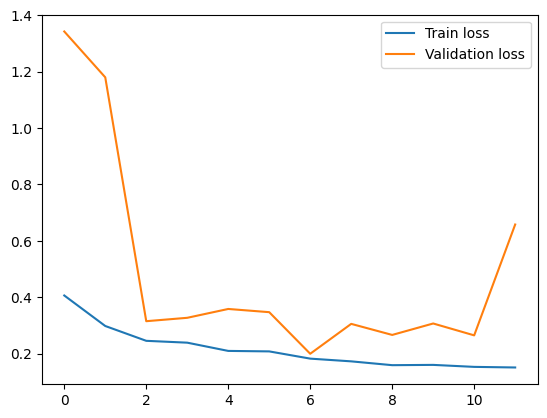

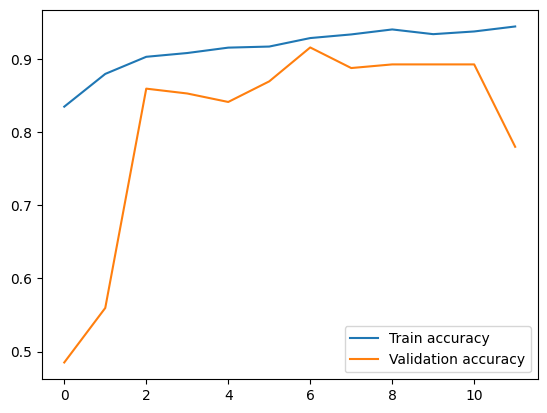

In [ ]:
h = history

# plot the loss value per epoch
plt.plot(h.epoch, h.history['loss'], label='Train loss')
plt.plot(h.epoch, h.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# plot the accuracy value per epoch
plt.plot(h.epoch, h.history['acc'], label='Train accuracy')
plt.plot(h.epoch, h.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.show()

## Model evaluation on test data

In [ ]:
# evaluation function
def metrics_(set_, actual, prediction):
    Accuracy = accuracy_score(actual, prediction)
    Recall = recall_score(actual, prediction)
    Precision = precision_score(actual, prediction)
    F1score = f1_score(actual, prediction)
    return set_, Accuracy, Recall, Precision, F1score

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

columns = ['Set','Accuracy','Recall','Precision','F1 score']
pd.DataFrame([columns, metrics_('Test', Y_test, y_pred)])

48/48 [==============================] - 1s 19ms/step


,0,1,2,3,4
0,Set,Accuracy,Recall,Precision,F1 score
1,Test,0.939695,0.934641,0.945767,0.940171


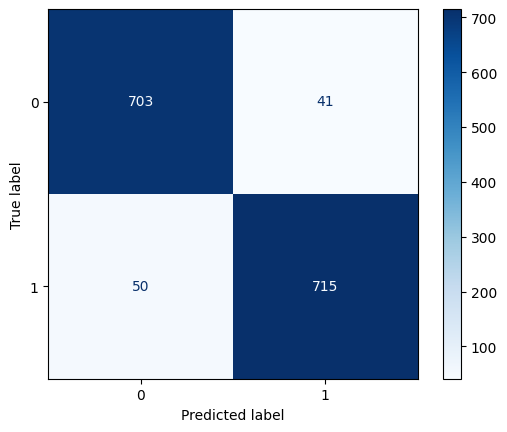

In [ ]:
cm = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap = 'Blues')


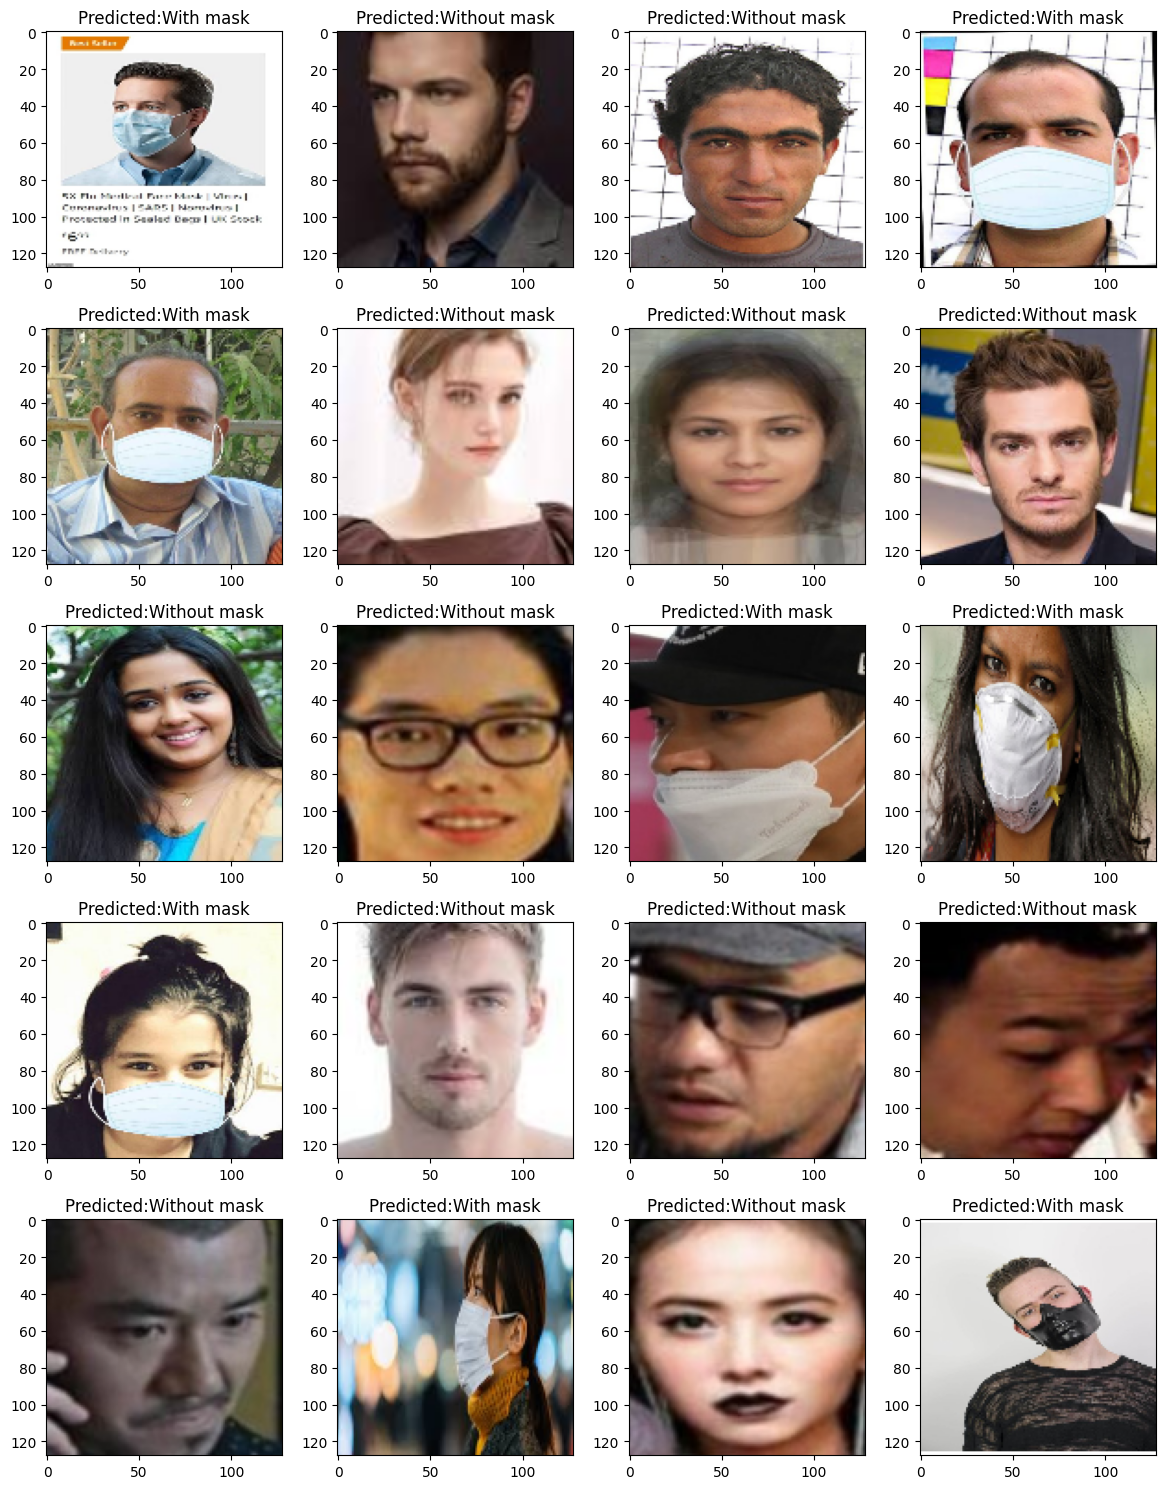

In [ ]:
# displaying some images with the model predictions
labels = {0: 'Without mask', 1: 'With mask'}

plt.figure(figsize=(12, 15))
for i, v in enumerate(np.random.randint(0,len(X_test), 20)):
    plt.subplot(5,4,i+1)
    plt.imshow((X_test[v]*255).astype("uint8"))
    prediction = y_pred[v]
    plt.title(f'Predicted:{labels[prediction]}')
    plt.tight_layout()

**Predictive System**

In [ ]:
## Prediction function

model = keras.models.load_model('saved_model.keras')
def pred(img_path):
    image = plt.imread(img_path)
    img = cv2.resize(image, (128,128))
    img = img.reshape(1,128,128,3)
    img = img / 255
    pred = np.argmax(model.predict(img))
    plt.imshow(image)
    if pred == 1:
        plt.title('The person in the picture is wearing a mask')
    else:
        plt.title('The person in the picture is not wearing a mask')
    plt.show()

1/1 [==============================] - 0s 247ms/step


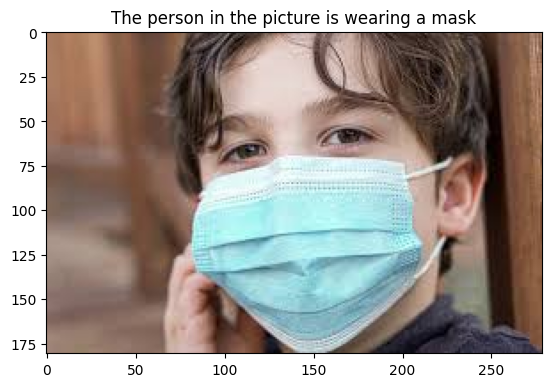

In [ ]:
pred('/content/drive/MyDrive/images for test/images (6).jfif')

1/1 [==============================] - 0s 38ms/step


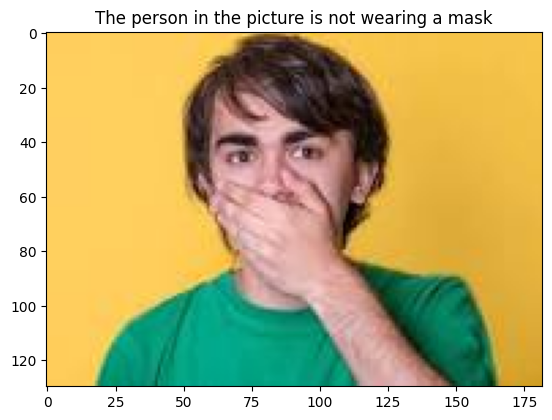

In [ ]:
pred('/content/test image.jfif')